In [1]:
%matplotlib inline
import importlib as imp
import matplotlib.pylab as plt 
import numpy as np 
import pandas as pd 
import seaborn as sns
sns.set_style('ticks');
current_colors = sns.color_palette()
sns.set_palette('Accent');

# Adjust all text and axes colors to black. default is some studip gray that appears to faint when printed 
from matplotlib import rc , rcParams
rc('axes',edgecolor='black')
rc('xtick',color='black',labelsize=15)
rc('ytick',color='black',labelsize=15)
rc('text',color='black')
rc('axes',labelcolor='black',linewidth=2.0)
rc('font',size=15)
#rcParams["patch.force_edgecolor"] = True

import Calculate_ABA_Finkelsteinlab_Diewertje as CalcABA
imp.reload(CalcABA);
import plotting_ABA_Diewertje as pltABA
imp.reload(pltABA);
import plotting_Boyle_Diewertje as plt_B
imp.reload(plt_B);

import sys 
sys.path.append('../code_general/')
import CRISPR_free_energy_landscape_Diewertje as FreeEnergy
imp.reload(FreeEnergy);
import read_model_ID;
imp.reload(read_model_ID);

import sys 
sys.path.append('../code_general_Finkelsteinlab/')
import plotting_Finkelsteinlab as plt_F
imp.reload(plt_F)


import analysis_SA_fits_Diewertje as SAfits
imp.reload(SAfits);



In [28]:
simset3 = []
no_good = []
# Used concentrations: [10,100]
chi_squared = [] 

#---------- collect simulations ---------------
for sim in range(1,25):
    sa = pd.read_csv('../Diewertje/15_5_2019_var_rates_conc3_eq/fit_15_5_2019_var_rates_conc3_eq_sim_' +str(sim)+'.txt', delimiter='\t', index_col=45)
    filename = '../Diewertje/15_5_2019_var_rates_conc3_eq/fit_15_5_2019_var_rates_conc3_eq_sim_' +str(sim) +'.txt'   
    chi_squared.append(sa.Potential.iloc[-1])
    simset3.append(filename)
        
    
best_fit_conc3 = simset3[np.argmin(chi_squared)]
best_fit_conc3

'../Diewertje/15_5_2019_var_rates_conc3_eq/fit_15_5_2019_var_rates_conc3_eq_sim_3.txt'

In [3]:
print('The chi-squared of the best fit is:',chi_squared[2])

The chi-squared of the best fit is: 68918.17982


In [4]:
# Load data
import Prepare_data_Simple as Pre
rawABA=pd.read_csv('../Data_ABA_Finkelsteinlab/TargetE-dCas9_AbsoluteABA_Canonical_OT-r_0-2.csv')
rawABA

# prepare data
import Prepare_data_Simple as pre
xdata,ydata,yerr=pre.Prepare_Cdata('../Data_ABA_Finkelsteinlab/','TargetE-dCas9_AbsoluteABA_Canonical_OT-r_0-2.csv')


In [5]:
# Load Parameters to calculate the chi-squared for best fit
import get_parameters_fit_Diewertje as getParm
Nparams=44
concentrations=np.array([1,30,100])
Param_conc3=getParm.load_simm_anneal(best_fit_conc3,Nparams)

ontarget ABA is: 5.1759594876624515
[8.30616917e-05 9.83251596e-08 1.42277301e-11 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]


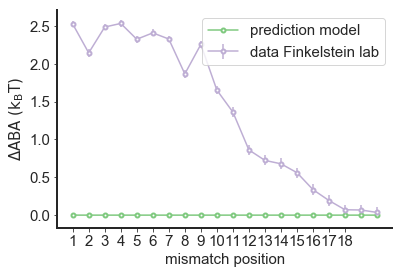

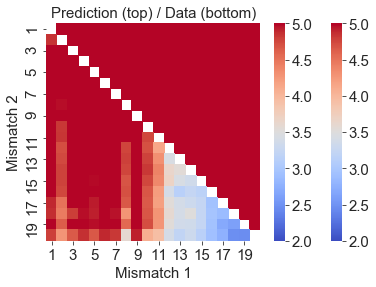

In [6]:
import plotting_simple_fit as pltS
T=60*10
guide_length=20
model_id = 'general_energies_no_kPR'

plt.figure()
_ = pltS.predict_single_mm(Param_conc3,model_id, T, guide_length, show_plot=True, show_data=True, data_file=rawABA)


plt.figure()
best_heatmap = pltABA.predict_double_mm(Param_conc3,model_id,T, guide_length, show_plot=True, show_data=True, data_file=rawABA)

# Cannot do those plots, because do not have block data
# plt.figure()
# _ = pltABA.predict_1D_mmblocks(Param_normal, model_id, T, guide_length, show_plot=True, show_data=True, data_file=rawABA)
# plt.figure()
# _ = pltABA.predict_block_mismatches(Param_normal, model_id, T,guide_length, show_plot=True, show_data=True, data_file=rawABA)



' \nTHIS IS BECAUSE I DID NOT FIT THE RATE, SO THE RATES ARE JUST A RANDOM NUMBER, \nAND THEREFORE IT IS NOT EQUILIBRATED AFTER 10 MIN, WHICH WE SIMULATED WITH \nTHE calcABA FUNCTION THAT I TRIED USING BEFORE\n'

<Figure size 432x288 with 0 Axes>

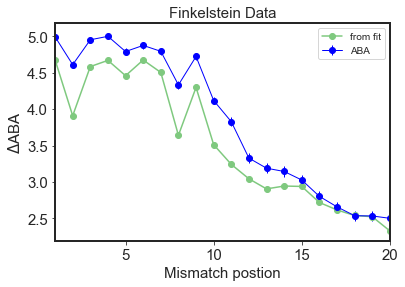

In [7]:
# to calculate the ABA with assuming equilibrium as we do in the chi-squared function
ABA_simple=[]
epsilon = Param_conc3[:-2]
for mm_pos in range(1, guide_length + 1):
    energies_simple=CalcABA.get_energies(epsilon,[mm_pos], guide_length)
    ABA_simple.append(-np.log(np.sum(np.exp(-np.cumsum(energies_simple)))))
ABA_simple

ABA_simple_on=-np.log(np.sum(np.exp(-np.cumsum(CalcABA.get_energies(epsilon,[],guide_length)))))
ABA_simple_on

ABA_simple_delta=ABA_simple-ABA_simple_on
ABA_simple_delta

def plot_single_mut_ABA(data, Mut_type, data_name='Finkelstein Data', Canonical=True, Plot=True):
    Mut_names = {'r': 'Mismatch', 'i': 'Insertion', 'd': 'Deletion'}
    Mut_name = Mut_names[Mut_type]

    data['Mutation Type'].fillna('', inplace=True)
    single_mut_data = data[(data['Canonical'] == Canonical) & (data['Mutation Type'] == Mut_type)][
        ['Mutation ID', 'ABA', 'error']]
    single_mut_data['ABA']=single_mut_data['ABA']#-single_mut_data['ABA'].iloc[0] # the row with the ontarget value
    single_mut_data['Position'] = single_mut_data['Mutation ID'].apply(lambda x: int(x.split(':')[1]))
    single_mut_data_mean = single_mut_data[['Position', 'ABA', 'error']].groupby(
        'Position').mean().reset_index()

    if Plot:
        single_mut_data_mean.plot(x='Position', y='ABA', yerr='error', marker='o', linewidth=1,
                                  color='blue')
        plt.xlabel(Mut_name + ' postion', fontsize=15)
        plt.ylabel('$\Delta$ABA', fontsize=15)
        plt.title(data_name, fontsize=15)
        if not Canonical:
            plt.title(data_name + ' - Noncanonical', fontsize=15)

    return single_mut_data_mean

plt.figure()
_=plot_single_mut_ABA(rawABA,'r',Plot=True)
plt.plot(range(1,21),ABA_simple,marker='o',label='from fit')
plt.legend()

# Now we do get a fit that looks okay. If there would be equilibrium after 10 
# min, it has to be possible to get this same graph with the calcABA funciton 
# as I tried before, bit this apparently does not work.
''' 
THIS IS BECAUSE I DID NOT FIT THE RATE, SO THE RATES ARE JUST A RANDOM NUMBER, 
AND THEREFORE IT IS NOT EQUILIBRATED AFTER 10 MIN, WHICH WE SIMULATED WITH 
THE calcABA FUNCTION THAT I TRIED USING BEFORE
'''


In [ ]:
# # This does exactly the same as above! To get scores
# selected_sims, selected_scores, scores = SAfits.select_on_prediction(simset3, 
#                                                          chi_squared, 
#                                                          percentage=0.05,
#                                                          Nparams=41,
#                                                          model_id='general_energies_no_kPR',
#                                                          precalculated=False, 
#                                                          score=None,
#                                                          save_scores=False, 
#                                                          filename='../data/25_10_2018/select_with_predcitions.txt'
#                                                          ) # do not use filename now

# plt.hist(scores, normed=False, bins=np.arange(0,max(scores),0.025), label='all fits: N= ' +str(len(scores)))
# plt.hist(selected_scores,normed=False, bins=np.arange(0,max(scores),0.025), label='selected fits: N= ' +str(len(selected_scores)));

# plt.axvline(0.05, linestyle='dashed', linewidth=3, color=sns.color_palette()[2], label='threshhold')


# plt.legend(fontsize=15);
# plt.xlabel('Relative difference in prediction per datapoint to data', fontsize=15);
# plt.ylabel('counts', fontsize=15);
# plt.xticks(fontsize=15);

# plt.yticks(fontsize=15);

# # Still old way of selecting: based on the best fit.
# # Not based on data

In [ ]:
# # --- make selection --- 
# simset3 = selected_sims 

# # --- store resulting fit parameters in a set of Dataframes --- 
# matches, mismatches, rates, landscape, free_energy, fast_Rloop = SAfits.process_SA_fits(simset3,44,'general_energies_no_kPR')
# forward_rates = rates[['sol_to_PAM','PAM_to_R1','internal']]
# matches.loc[best_fit_conc3]

In [ ]:
# # --- (microscopic) free-energy landscape --- 
# plt.figure()
# Nparams=41
# for filename in simset3:
#     parameters = plt_B.load_simm_anneal(filename, Nparams)
#     parameters[0]=3.5 # if want to fix epsilon PAM
#     Energy_landscape, FreeEnergy_landscape = FreeEnergy.plot_free_energy_landscape(parameters,model_id='fixed_rates',show_plot=False);
#     #plt.figure()
#     plt.plot(np.array(Energy_landscape),color=sns.color_palette()[0])
# lowest_chi_squared = np.array( landscape.loc[best_fit_conc3] )


# plt.plot(np.array(lowest_chi_squared), color='#f768a1' , 
#          marker='o', 
#          lw=3,
#          markersize =8,
#          markerfacecolor='white',
#          markeredgewidth= 2,
#          label='best fit');

# LandscapeMED = landscape[landscape.columns[:]].median()
# plt.plot(np.array(LandscapeMED),color='black' , 
#          marker='o',
#          lw=3,
#          markersize =8,
#          markerfacecolor='white',
#          markeredgewidth= 2,
#          label='median');

# plt.legend(fontsize=15,frameon=True)
# plt.xlim(-1,22)
# plt.xticks(list(range(0,22)),['S','P']+list(LandscapeMED.index[2:]),  fontsize=15);
# plt.yticks(fontsize=15);
# plt.xlabel('Targeting progression',fontsize=15)
# plt.ylabel('On-target energy landscape ($k_BT$)',fontsize=15)
# plt.grid('on')
# sns.despine();


# Now selection based on agreement with data

In [8]:
def select_on_prediction_WA(simset,
                            percentage=0.1,
                            Nparams=43,
                            model_id='general_energies_no_kPR',
                            path='../Data_Boyle/',
                            replica='1'):
    # in my case replica is filename!
    scores = []
    for sim in simset:
        #print sim
        parameters = getParm.load_simm_anneal(sim, Nparams)
        score, _, _ = predict_train(parameters, model_id=model_id, path=path, replica=replica, Plot=False)
        scores.append(score)
    scores = np.array(scores)
    simset = np.array(simset)
    selected_scores = scores[scores <= percentage]
    selected_sims = simset[scores <= percentage]
    return selected_sims, selected_scores, scores

import os
import numpy as np
import pandas as pd
import Boyle_data_processing as process
import CRISPR_dCas9_binding_curve_Boyle as dCas9
import matplotlib.pylab as plt
import Prepare_data_Simple as prep

import Calculate_ABA_Finkelsteinlab_Diewertje as ABA


def Weighted_average(row):
    y = np.array(row['ydata'])
    e = np.array(row['yerr'])
    wa=np.average(y, weights=e ** -2, axis=0)
    return wa


def calc_Weighted_average(path='../Data_Boyle/', replica='1', outputdirectory='../Data_Boyle/Weighted_Avarage/',
                          save=True):
    # For me replica is the filename
    xdata, ydata, yerr = prep.Prepare_Cdata(path=path,filename=replica)
    data = pd.DataFrame(columns=['xdata', 'ydata', 'yerr'])
    data['xdata'] = xdata
    data['ydata'] = ydata
    data['yerr'] = yerr
    wa = []
    for i in data.index:
        wa.append(Weighted_average(data.loc[i]))
    WA = pd.DataFrame(columns=['MM_pos', 'WA_data'])
    WA.MM_pos = xdata
    WA.WA_data = wa
    return WA


def predict_train(parameters, model_id='general_energies_no_kPR', path='../Data_Boyle/', replica='1', Plot=True):
    wa = calc_Weighted_average(path=path, replica=replica, save=False)
    prediction=wa.copy()
    concentrations=np.array([0.1,0.3,1.,3.,10.,30.,100.,300.])
    reference=1
    
    ABA_simple=[]
    epsilon = parameters[:-2]
    for mm_pos in prediction['MM_pos']:
        energies_simple=CalcABA.get_energies(epsilon,[mm_pos], guide_length)
        ABA_simple.append(-np.log(np.sum(np.exp(-np.cumsum(energies_simple)))))
    ABA_simple
    
    prediction['WA_model']=ABA_simple
    score = prediction.dropna().apply(lambda x: np.abs(x['WA_data'] - x['WA_model']) / x['WA_data'], axis=1).mean()
    corr=0
    return score, corr, prediction



In [22]:
# select based on dataset instead of best fit:
selected_sims, selected_scores, scores = select_on_prediction_WA(simset3,
                                                                percentage=0.022,
                                                                model_id='general_energies_no_kPR',
                                                                path='../Data_ABA_Finkelsteinlab/',
                                                                replica='TargetE-dCas9_AbsoluteABA_Canonical_OT-r_0-2.csv')
# replica is filename of the data in my case!

In [23]:
scores

array([0.0201951 , 0.02326243, 0.01685169, 0.02986696, 0.0211741 ,
       0.0297232 , 0.02205016, 0.0213067 , 0.01893996, 0.02227085,
       0.0266676 , 0.02450663, 0.02071577, 0.01732201, 0.01740646,
       0.02140235, 0.01754677, 0.02175135, 0.01986117, 0.02277195,
       0.02308136, 0.02405462, 0.01889114, 0.02096949])

C:\Users\Diewertje\Python\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
C:\Users\Diewertje\Python\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


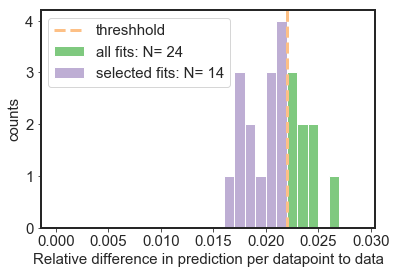

In [24]:
plt.hist(scores, normed=False, bins=np.arange(0,max(scores),0.001), label='all fits: N= ' +str(len(scores)))
plt.hist(selected_scores,normed=False, bins=np.arange(0,max(scores),0.001), label='selected fits: N= ' +str(len(selected_scores)));

plt.axvline(0.022, linestyle='dashed', linewidth=3, color=sns.color_palette()[2], label='threshhold')


plt.legend(fontsize=15);
plt.xlabel('Relative difference in prediction per datapoint to data', fontsize=15);
plt.ylabel('counts', fontsize=15);
plt.xticks(fontsize=15);

plt.yticks(fontsize=15);

# Plot of weighted average

In [12]:
#------------To plot weighted average--------
import os
import numpy as np
import pandas as pd
import Boyle_data_processing as process
import CRISPR_dCas9_binding_curve_Boyle as dCas9
import matplotlib.pylab as plt
import Prepare_data_Simple as prep

import Calculate_ABA_Finkelsteinlab_Diewertje as ABA

def Weighted_average(row):
    y = np.array(row['ydata'])
    e = np.array(row['yerr'])
    wa=np.average(y, weights=e ** -2, axis=0)
    return wa


def calc_Weighted_average(path='../Data_Boyle/', replica='1', outputdirectory='../Data_Boyle/Weighted_Avarage/',
                          save=True):
    # For me replica is the filename
    xdata, ydata, yerr = prep.Prepare_Cdata(path=path,filename=replica)
    data = pd.DataFrame(columns=['xdata', 'ydata', 'yerr'])
    data['xdata'] = xdata
    data['ydata'] = ydata
    data['yerr'] = yerr
    wa = []
    for i in data.index:
        wa.append(Weighted_average(data.loc[i]))
    WA = pd.DataFrame(columns=['MM_pos', 'WA_data'])
    WA.MM_pos = xdata
    WA.WA_data = wa
    return WA


percentage=0.1,
model_id='general_energies_no_kPR'
path='../Data_ABA_Finkelsteinlab/'
replica='TargetE-dCas9_AbsoluteABA_Canonical_OT-r_0-2.csv'

WA=calc_Weighted_average(path,replica,save=False)
WA['WA_data_delta']=WA['WA_data']-2.5545002878227865 
# substract ontarget to go to delta ABA


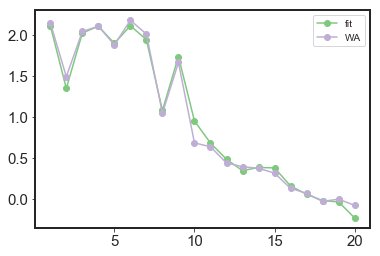

In [13]:
WAsingle=[]
singlePos=[]
for i in range(len(WA)):
    if (len(WA['MM_pos'][i])==1):
        singlePos.append(WA['MM_pos'][i])
        WAsingle.append(WA['WA_data_delta'][i])

WAsingle_ordered=np.empty(len(WAsingle)+1)
for i in range(1,len(WAsingle)+1):
    WAsingle_ordered[singlePos[i-1]]=WAsingle[i-1]
len(WAsingle_ordered)
plt.figure()
plt.plot(range(1,21),np.array(ABA_simple)-2.5545002878227865,marker='o',label='fit')
plt.plot(range(1,21),WAsingle_ordered[1:],marker='o',label='WA')
plt.legend()

Text(0.5, 1.0, 'Prediction (top) / WA (bottom)')

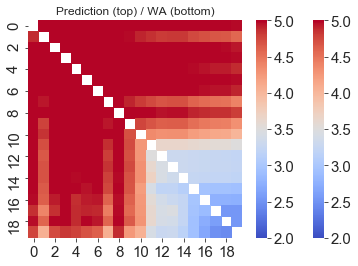

In [14]:
#-----For double mismatches-----
WAdouble=[]
doublePos=[]
for i in range(len(WA)):
    if (len(WA['MM_pos'][i])==2):
        doublePos.append(WA['MM_pos'][i])
        WAdouble.append(WA['WA_data'][i])
mapABA=np.zeros([20,20])
mapABA[:]=np.nan
for i in range(len(doublePos)):
    mapABA[doublePos[i][0]-1,doublePos[i][1]-1]=WAdouble[i]

    
def predict_double_mm(parameters, model_id, T=60 * 10, guide_length=20, show_plot=True, show_data=True,
                      data_file='../Data_ABA_Finkelsteinlab/champ-cas9-cas12a-data/cas9-target-e-replicate-1-delta-abas-processed.csv'):
    concentrations = np.array([0.1, 0.3, 1, 3, 10, 30, 100, 300]) #2 ** np.array(range(0, 11)) * 0.5
    reference_conc = 1 #10
    
    ontarget_ABA = 42#CalcABA.calc_ABA(parameters, concentrations, reference_conc,
                                   # mismatch_positions=[],
                                   # model_id=model_id,
                                   # guide_length=20,
                                    #T=60 * 10)

    ABA_simple = np.zeros((guide_length, guide_length))
    epsilon = parameters[:-2]
    for first_mm in range(1, guide_length + 1):
        for second_mm in range(1, guide_length + 1):
            ABA_simple[first_mm - 1, second_mm - 1] = -np.log(np.sum(np.exp(-np.cumsum(CalcABA.get_energies(epsilon,[first_mm,second_mm], guide_length)))))
            
        # this should be calc_delta_ABA if we do not work wit rawABA dataset

    if show_plot:
        axHeatmap = sns.heatmap(ABA_simple, cmap='coolwarm', mask=np.tril(ABA_simple),vmin=2, vmax=5)
        plt.grid()
        ax = plt.gca()
        ax.set_xticklabels(list(map(lambda x: str(int(x)), ax.get_xticks() + 0.5)), fontsize=15);
        ax.set_yticklabels(list(map(lambda x: str(int(x)), 20 - ax.get_yticks() + 0.5)), fontsize=15, rotation=0);
        str_title = 'Prediction (top)'

        if show_data:
            IlyaData = data_file #pd.read_csv(data_file)
            _, double_mut_map = pltF.plot_double_mut_data(IlyaData, data_colname='ABA', Mut_type='r', Canonical=True, Ng=20, data_name='Data', Plot=False,logplot=False, SaveFigures=False, figure_name='./Figure.pdf')
            # data_colname = [delta ABA (kBT)]  if we use not rawABA dataset!
            #plot_double_mut_ABA(data=IlyaData, Mut_type='r', Plot=False)
            sns.heatmap(double_mut_map, cmap='coolwarm', ax=axHeatmap, vmin=2, vmax=5)
            str_title += ' / Data (bottom)'
        plt.title(str_title, fontsize=15)
        plt.xlabel('Mismatch 1', fontsize=15)
        plt.ylabel('Mismatch 2', fontsize=15)
    return ABA_simple
    
import seaborn as sns
plt.figure()
best_heatmap =predict_double_mm(Param_conc3,model_id,T, guide_length, show_plot=True, show_data=False, data_file=rawABA)

sns.heatmap(mapABA.transpose(), cmap='coolwarm', cbar=True, vmin=2,vmax=5)
plt.title('Prediction (top) / WA (bottom)')

# To calculate the chisquared of WA compared to data

In [15]:
score,corr,prediction=predict_train(Param_conc3,
                                    model_id='general_energies_no_kPR',
                                    path=path,replica=replica,Plot=True)
prediction
parts=[]
for i in range(len(ydata)):
    parts.append(sum((np.array(ydata[i])-(prediction['WA_model'][i]*np.ones(len(ydata[i]))))**2/(np.array(yerr[i])**2)))
    
chi_squared_WA=sum(np.array(parts))

In [16]:
chi_squared_WA

68918.179820043

In [17]:
np.abs(np.array(chi_squared)-chi_squared_WA)/chi_squared_WA

array([7.20059392e-02, 1.23324848e-01, 6.23941457e-13, 4.56104822e-01,
       5.15306369e-02, 5.24662135e-01, 6.17591500e-02, 6.81219511e-02,
       1.95025579e-02, 8.84400839e-02, 2.66543666e-01, 2.56958626e-01,
       5.46665538e-02, 7.60255747e-04, 3.86748106e-03, 5.96543396e-02,
       1.40561833e-02, 5.95413250e-02, 3.40937120e-02, 1.12039885e-01,
       8.49003721e-02, 8.21984547e-02, 3.82928258e-02, 6.29580868e-02])

# FROM NOW IT IS NORMAL CODE AGAIN

In [25]:
# --- make selection --- 
simset3 = selected_sims 

# --- store resulting fit parameters in a set of Dataframes --- 
matches, mismatches, rates, landscape, free_energy, fast_Rloop = SAfits.process_SA_fits(simset3,44,'general_energies_no_kPR')
forward_rates = rates[['sol_to_PAM','PAM_to_R1','internal']]
matches.loc[best_fit_conc3]

PAM    3.500000
1     -9.384326
2     -5.764141
3     -5.557904
4      8.121149
5     -4.524694
6     -3.163827
7      4.163410
8      0.926796
9      8.003526
10     6.488674
11     1.654590
12    -0.207306
13    -6.842964
14     5.012060
15     1.958556
16    -0.232552
17     0.409232
18    -8.056285
19     8.227962
20     2.317167
Name: ../Diewertje/15_5_2019_var_rates_conc3_eq/fit_15_5_2019_var_rates_conc3_eq_sim_3.txt, dtype: float64

C:\Users\Diewertje\Python\lib\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


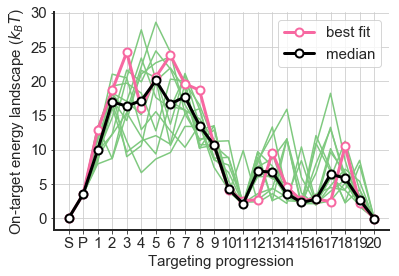

In [26]:
# --- (microscopic) free-energy landscape --- 
plt.figure()
Nparams=41
for filename in simset3:
    parameters = plt_B.load_simm_anneal(filename, Nparams)
    parameters[0]=3.5 # if want to fix epsilon PAM
    Energy_landscape, FreeEnergy_landscape = FreeEnergy.plot_free_energy_landscape(parameters,model_id='fixed_rates',show_plot=False);
    #plt.figure()
    plt.plot(np.array(Energy_landscape),color=sns.color_palette()[0])
lowest_chi_squared = np.array( landscape.loc[best_fit_conc3] )


plt.plot(np.array(lowest_chi_squared), color='#f768a1' , 
         marker='o', 
         lw=3,
         markersize =8,
         markerfacecolor='white',
         markeredgewidth= 2,
         label='best fit');

LandscapeMED = landscape[landscape.columns[:]].median()
plt.plot(np.array(LandscapeMED),color='black' , 
         marker='o',
         lw=3,
         markersize =8,
         markerfacecolor='white',
         markeredgewidth= 2,
         label='median');

plt.legend(fontsize=15,frameon=True)
plt.xlim(-1,22)
plt.xticks(list(range(0,22)),['S','P']+list(LandscapeMED.index[2:]),  fontsize=15);
plt.yticks(fontsize=15);
plt.xlabel('Targeting progression',fontsize=15)
plt.ylabel('On-target energy landscape ($k_BT$)',fontsize=15)
plt.grid('on')
sns.despine();


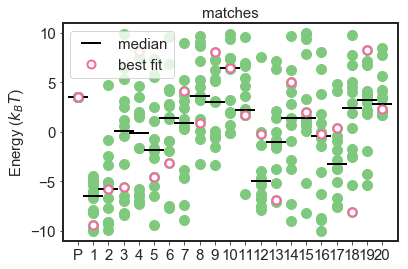

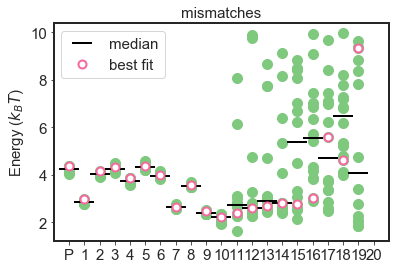

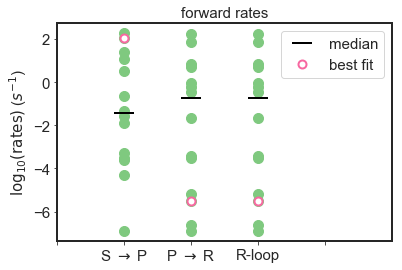

In [27]:
# ---- show fluctuations in parameter sets --- 
# THIS IS THE RESULT

# --- Matches ---
# MAYBE WE WANT TO NEGATE (multiply by -1 all the epsilonC to have the same sign convention as EpsilonPAM and EpsilonI)
plt.figure()
for sim in simset3:
    matches.loc[sim].plot(marker='o',markersize=10,linestyle='', color=sns.color_palette()[0], alpha=1.0,label='')

matches.median().plot(color='black',
            linestyle='',
             marker='_', 
             lw=4,
             markersize =20,
             markerfacecolor='white',
             markeredgewidth= 2,
        label='median')    

matches.loc[best_fit_conc3].plot(color='#f768a1',
            linestyle='',
             marker='o', 
             lw=3,
             markersize =8,
             markerfacecolor='white',
             markeredgewidth= 2,
        label='best fit')



plt.title('matches',fontsize=15)
plt.xticks(list(range(0,21)),['P']+list(range(1,21)),fontsize=15);
plt.xlim(-1,21);
plt.yticks(fontsize=15);
plt.ylabel('Energy ($k_BT$)',fontsize=15);
plt.legend(fontsize=15,frameon=True);

# --- Mismatches --- 
plt.figure()
for sim in simset3:
    mismatches.loc[sim].plot(marker='o',markersize=10,linestyle='', color=sns.color_palette()[0], alpha=1.0,label='')

mismatches.median().plot(color='black',
            linestyle='',
             marker='_', 
             lw=4,
             markersize =20,
             markerfacecolor='white',
             markeredgewidth= 2,
        label='median')    
    

mismatches.loc[best_fit_conc3].plot(color='#f768a1',
            linestyle='',
             marker='o', 
             lw=3,
             markersize =8,
             markerfacecolor='white',
             markeredgewidth= 2,
        label='best fit')



plt.title('mismatches',fontsize=15)
plt.xticks(list(range(0,21)),['P']+list(range(1,21)),fontsize=15);
plt.xlim(-1,21);
plt.yticks(fontsize=15);
plt.ylabel('Energy ($k_BT$)',fontsize=15);
plt.legend(fontsize=15,frameon=True);


# --- 10log of the forward rates --- 
plt.figure()
for sim in simset3:
    forward_rates.loc[sim].apply(np.log10).plot(marker='o',markersize=10,linestyle='', color=sns.color_palette()[0], alpha=1.0,label='')

forward_rates.median().apply(np.log10).plot(color='black',
            linestyle='',
             marker='_', 
             lw=4,
             markersize =20,
             markerfacecolor='white',
             markeredgewidth= 2,
        label='median')    
    
    

forward_rates.loc[best_fit_conc3].apply(np.log10).plot(color='#f768a1',
            linestyle='',
             marker='o', 
             lw=3,
             markersize =8,
             markerfacecolor='white',
             markeredgewidth= 2,
        label='best fit')



plt.title('forward rates',fontsize=15)
plt.xticks(range(-1,4),['',r'S $\rightarrow$ P',r'P $\rightarrow$ R','R-loop',''],fontsize=15);
plt.xlim(-1,4);
plt.yticks(fontsize=15);
plt.ylabel(r'$\log_{10}(\rm{rates})$ ($s^{-1}$)',fontsize=15);
plt.legend(fontsize=15,frameon=True);




In [29]:
# select based on dataset instead of best fit:
selected_sims, selected_scores, scores = select_on_prediction_WA(simset3,
                                                                percentage=0.018,
                                                                model_id='general_energies_no_kPR',
                                                                path='../Data_ABA_Finkelsteinlab/',
                                                                replica='TargetE-dCas9_AbsoluteABA_Canonical_OT-r_0-2.csv')
# replica is filename of the data in my case!

C:\Users\Diewertje\Python\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
C:\Users\Diewertje\Python\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


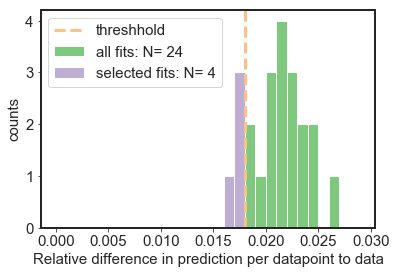

In [30]:
plt.hist(scores, normed=False, bins=np.arange(0,max(scores),0.001), label='all fits: N= ' +str(len(scores)))
plt.hist(selected_scores,normed=False, bins=np.arange(0,max(scores),0.001), label='selected fits: N= ' +str(len(selected_scores)));

plt.axvline(0.018, linestyle='dashed', linewidth=3, color=sns.color_palette()[2], label='threshhold')


plt.legend(fontsize=15);
plt.xlabel('Relative difference in prediction per datapoint to data', fontsize=15);
plt.ylabel('counts', fontsize=15);
plt.xticks(fontsize=15);

plt.yticks(fontsize=15);

In [31]:
# --- make selection --- 
simset3 = selected_sims 

# --- store resulting fit parameters in a set of Dataframes --- 
matches, mismatches, rates, landscape, free_energy, fast_Rloop = SAfits.process_SA_fits(simset3,44,'general_energies_no_kPR')
forward_rates = rates[['sol_to_PAM','PAM_to_R1','internal']]
matches.loc[best_fit_conc3]

PAM    3.500000
1     -9.384326
2     -5.764141
3     -5.557904
4      8.121149
5     -4.524694
6     -3.163827
7      4.163410
8      0.926796
9      8.003526
10     6.488674
11     1.654590
12    -0.207306
13    -6.842964
14     5.012060
15     1.958556
16    -0.232552
17     0.409232
18    -8.056285
19     8.227962
20     2.317167
Name: ../Diewertje/15_5_2019_var_rates_conc3_eq/fit_15_5_2019_var_rates_conc3_eq_sim_3.txt, dtype: float64

C:\Users\Diewertje\Python\lib\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


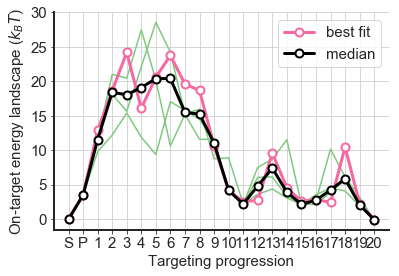

In [32]:
# --- (microscopic) free-energy landscape --- 
plt.figure()
Nparams=41
for filename in simset3:
    parameters = plt_B.load_simm_anneal(filename, Nparams)
    parameters[0]=3.5 # if want to fix epsilon PAM
    Energy_landscape, FreeEnergy_landscape = FreeEnergy.plot_free_energy_landscape(parameters,model_id='fixed_rates',show_plot=False);
    #plt.figure()
    plt.plot(np.array(Energy_landscape),color=sns.color_palette()[0])
lowest_chi_squared = np.array( landscape.loc[best_fit_conc3] )


plt.plot(np.array(lowest_chi_squared), color='#f768a1' , 
         marker='o', 
         lw=3,
         markersize =8,
         markerfacecolor='white',
         markeredgewidth= 2,
         label='best fit');

LandscapeMED = landscape[landscape.columns[:]].median()
plt.plot(np.array(LandscapeMED),color='black' , 
         marker='o',
         lw=3,
         markersize =8,
         markerfacecolor='white',
         markeredgewidth= 2,
         label='median');

plt.legend(fontsize=15,frameon=True)
plt.xlim(-1,22)
plt.xticks(list(range(0,22)),['S','P']+list(LandscapeMED.index[2:]),  fontsize=15);
plt.yticks(fontsize=15);
plt.xlabel('Targeting progression',fontsize=15)
plt.ylabel('On-target energy landscape ($k_BT$)',fontsize=15)
plt.grid('on')
sns.despine();


# To compare with Boyle e-mailed file + rates

In [ ]:
# To load other paramter sets, to choose one with low Ksp, to see if that will give a good fit.
import plotting_Boyle_Diewertje as plt_B
model_id = 'general_energies_no_kPR'
# filename = simset[np.argsort(chi_squared)[3]]
filename = np.array(['../data/22_3_2019/fit_22_3_2019_sim_4.txt',
       '../data/22_3_2019/fit_22_3_2019_sim_5.txt',
       '../data/22_3_2019/fit_22_3_2019_sim_6.txt',
       '../data/22_3_2019/fit_22_3_2019_sim_7.txt',
       '../data/22_3_2019/fit_22_3_2019_sim_9.txt',
       '../data/22_3_2019/fit_22_3_2019_sim_13.txt',
       '../data/22_3_2019/fit_22_3_2019_sim_17.txt',
       '../data/22_3_2019/fit_22_3_2019_sim_21.txt',
       '../data/22_3_2019/fit_22_3_2019_sim_26.txt',
       '../data/22_3_2019/fit_22_3_2019_sim_31.txt',
       '../data/22_3_2019/fit_22_3_2019_sim_33.txt',
       '../data/22_3_2019/fit_22_3_2019_sim_35.txt',
       '../data/22_3_2019/fit_22_3_2019_sim_47.txt',
       '../data/22_3_2019/fit_22_3_2019_sim_49.txt',
       '../data/22_3_2019/fit_22_3_2019_sim_50.txt',
       '../data/22_3_2019/fit_22_3_2019_sim_51.txt',
       '../data/22_3_2019/fit_22_3_2019_sim_53.txt',
       '../data/22_3_2019/fit_22_3_2019_sim_54.txt',
       '../data/22_3_2019/fit_22_3_2019_sim_56.txt',
       '../data/22_3_2019/fit_22_3_2019_sim_59.txt',
       '../data/22_3_2019/fit_22_3_2019_sim_63.txt',
       '../data/22_3_2019/fit_22_3_2019_sim_67.txt',
       '../data/22_3_2019/fit_22_3_2019_sim_68.txt',
       '../data/22_3_2019/fit_22_3_2019_sim_69.txt',
       '../data/22_3_2019/fit_22_3_2019_sim_79.txt',
       '../data/22_3_2019/fit_22_3_2019_sim_80.txt',
       '../data/22_3_2019/fit_22_3_2019_sim_82.txt',
       '../data/22_3_2019/fit_22_3_2019_sim_83.txt',
       '../data/22_3_2019/fit_22_3_2019_sim_87.txt',
       '../data/22_3_2019/fit_22_3_2019_sim_90.txt',
       '../data/22_3_2019/fit_22_3_2019_sim_97.txt'])
Nparams = 43
ref_Ksp=10000 # just a big number
for i in range(0,len(filename)):
    p= plt_B.load_simm_anneal(filename[i], Nparams)
    Ksp=10**p[-2]/10
    if(Ksp<ref_Ksp):
        ref_Ksp=Ksp
        parameters=p
        name=filename[i]


In [ ]:
parameters

In [ ]:
# first run the cell before!!!
parameters
rates=parameters[-2].copy()
rates=rates-1
parameters[-2]=rates
parameters
epsilonPAM=parameters[0].copy()
epsilonPAM=epsilonPAM+np.log(10)
parameters[0]=epsilonPAM
parameters

In [ ]:
len(parameters)

In [ ]:
# to get chi-squared for Boyle
import Chisq_Finkelstein as chin
chi_BoyleR=[]
for i in range(0,len(xdata)):
    chi_BoyleR.append(chin.calc_Chi_square(parameters,xdata[i],ydata[i],yerr[i],
                                concentrations, reference=1, 
                                ontarget_ABA=42,guide_length=20,
                                model_id='general_energies_no_kPR'))

In [ ]:
# to plot boyle in this graph
Param_Boyle=np.loadtxt('parameters_Boyle.txt')
epsC = np.array(Param_Boyle[:21].copy())
epsC[0]+=np.log(10)
epsC[1:] *= -1

epsCr = np.array(parameters[:21].copy())
epsCr[0]+=np.log(10)
epsCr[1:] *= -1

epsC_fit=np.array(Param_conc3[:21]).copy()
epsC_fit[0]=epsC[0]
epsC_fit[1:] *= -1


plt.plot(range(0,21),np.cumsum(epsC_fit),marker='o',label='Fit')
plt.plot(range(0,21),np.cumsum(epsC),marker='o',label='Boyle (e-mail)')
plt.plot(range(0,21),np.cumsum(epsCr),marker='o',label='Boyle (rates)')
plt.title('Epsilon C')
plt.legend()

In [ ]:
# to get chi-squared for Boyle
import Chisq_Finkelstein as chin
chi_Boyle=[]
for i in range(0,len(xdata)):
    chi_Boyle.append(chin.calc_Chi_square(Param_Boyle,xdata[i],ydata[i],yerr[i],
                                concentrations, reference=1, 
                                ontarget_ABA=42,guide_length=20,
                                model_id='init_limit_general_energies_v2'))
print('The chi-squared of Boyle is: ',np.sum(chi_Boyle))

In [ ]:
print('The chi-squared of the best fit is:',chi_squared[3-1])
print('The chi-squared of Boyle (e-mailed) is: ',np.sum(chi_Boyle))
print('The chi-squared of Boyle from rates is:',np.sum(chi_BoyleR) )

In [ ]:
plt.plot(range(0,20),Param_conc3[21:],marker='o',label='Fit')
plt.plot(range(0,20),Param_Boyle[21:41],marker='o',label='Boyle (e-mail)')
plt.plot(range(0,20),parameters[21:41],marker='o',label='Boyle (rates)')
plt.title('Epsilon I')
plt.legend()

# Try prediction of on target for all boyle parameters

In [ ]:
# To load other paramter sets, to choose one with low Ksp, to see if that will give a good fit.
import plotting_Boyle_Diewertje as plt_B
import Calculate_ABA_Finkelsteinlab_Diewertje as CalcABA
model_id = 'general_energies_no_kPR'
filename = np.array(['../data/22_3_2019/fit_22_3_2019_sim_4.txt',
       '../data/22_3_2019/fit_22_3_2019_sim_5.txt',
       '../data/22_3_2019/fit_22_3_2019_sim_6.txt',
       '../data/22_3_2019/fit_22_3_2019_sim_7.txt',
       '../data/22_3_2019/fit_22_3_2019_sim_9.txt',
       '../data/22_3_2019/fit_22_3_2019_sim_13.txt',
       '../data/22_3_2019/fit_22_3_2019_sim_17.txt',
       '../data/22_3_2019/fit_22_3_2019_sim_21.txt',
       '../data/22_3_2019/fit_22_3_2019_sim_26.txt',
       '../data/22_3_2019/fit_22_3_2019_sim_31.txt',
       '../data/22_3_2019/fit_22_3_2019_sim_33.txt',
       '../data/22_3_2019/fit_22_3_2019_sim_35.txt',
       '../data/22_3_2019/fit_22_3_2019_sim_47.txt',
       '../data/22_3_2019/fit_22_3_2019_sim_49.txt',
       '../data/22_3_2019/fit_22_3_2019_sim_50.txt',
       '../data/22_3_2019/fit_22_3_2019_sim_51.txt',
       '../data/22_3_2019/fit_22_3_2019_sim_53.txt',
       '../data/22_3_2019/fit_22_3_2019_sim_54.txt',
       '../data/22_3_2019/fit_22_3_2019_sim_56.txt',
       '../data/22_3_2019/fit_22_3_2019_sim_59.txt',
       '../data/22_3_2019/fit_22_3_2019_sim_63.txt',
       '../data/22_3_2019/fit_22_3_2019_sim_67.txt',
       '../data/22_3_2019/fit_22_3_2019_sim_68.txt',
       '../data/22_3_2019/fit_22_3_2019_sim_69.txt',
       '../data/22_3_2019/fit_22_3_2019_sim_79.txt',
       '../data/22_3_2019/fit_22_3_2019_sim_80.txt',
       '../data/22_3_2019/fit_22_3_2019_sim_82.txt',
       '../data/22_3_2019/fit_22_3_2019_sim_83.txt',
       '../data/22_3_2019/fit_22_3_2019_sim_87.txt',
       '../data/22_3_2019/fit_22_3_2019_sim_90.txt',
       '../data/22_3_2019/fit_22_3_2019_sim_97.txt'])
Nparams = 43
ref_Ksp=10000 # just a big number
ontarget_ABA=[]
for i in range(0,len(filename)):
    parameters= plt_B.load_simm_anneal(filename[i], Nparams)
    concentrations=np.array([0.1, 0.3, 1, 3, 10, 30, 100, 300]) #2 ** np.array(range(0, 11)) * 0.5
    reference_conc = 10 
    ontarget_ABA.append(CalcABA.calc_ABA(parameters, concentrations, reference_conc,
                                         mismatch_positions=[],model_id=model_id,
                                         guide_length=20,T=60 * 10))
    

In [ ]:
ontarget_ABA

# Analyse best fits

In [ ]:
plt.figure()
Nparams=41
model_id='fixed_rates'
for filename in selected_sims:
    parameters = plt_B.load_simm_anneal(filename, Nparams)
    _ = pltS.predict_single_mm(parameters,model_id, T, guide_length, show_plot=True, show_data=True, data_file=rawABA)

# Compare best fit to not selecte fits

In [ ]:
selected_sims

In [ ]:
best_fit_conc3

In [ ]:
simset3[8:13]

In [ ]:
plt.figure()
Nparams=41
model_id='fixed_rates'
not_selected=simset3[8:13]

cmap = plt.get_cmap('Set3')
colors = [cmap(i) for i in np.linspace(0, 1, len(not_selected))] 
count=0 

for filename in not_selected:
    parameters = plt_B.load_simm_anneal(filename, Nparams)
    #_ = pltS.predict_single_mm(parameters,model_id, T, guide_length, show_plot=True, show_data=True, data_file=rawABA)
    concentrations = np.array([0.1, 0.3, 1, 3, 10, 30, 100, 300]) #2 ** np.array(range(0, 11)) * 0.5
    reference_conc = 1 #10
    ontarget_ABA = CalcABA.calc_ABA(parameters, concentrations, reference_conc,
                                    mismatch_positions=[],
                                    model_id=model_id,
                                    guide_length=20,
                                    T=60 * 10)

    delta_ABA = np.zeros(guide_length)
    for mm_pos in range(1, guide_length + 1):
        delta_ABA[mm_pos - 1] = CalcABA.calc_delta_ABA(parameters, concentrations, reference_conc,
                                                        mismatch_positions=[mm_pos],
                                                       model_id=model_id,
                                                       guide_length=guide_length,
                                                       T=T,
                                                       ontarget_ABA=ontarget_ABA)
    
    ax = plt.plot(range(1, guide_length + 1),
                  delta_ABA,
                  marker='o',
                  markersize=4,
                  markerfacecolor='white',
                  markeredgewidth=2,
                  linestyle='solid',
                  c=colors[count])

    sns.despine()
    plt.xticks(range(1, 19), fontsize=15);
    plt.yticks(fontsize=15);
    plt.xlabel('mismatch position', fontsize=15);
    plt.ylabel(r'$\Delta \rm{ABA} \ (k_BT)$', fontsize=15)
    count=count+1

# to plot the best if tin the same graph
parameters = plt_B.load_simm_anneal(filename, Nparams)
#_ = pltS.predict_single_mm(parameters,model_id, T, guide_length, show_plot=True, show_data=True, data_file=rawABA)
concentrations = np.array([0.1, 0.3, 1, 3, 10, 30, 100, 300]) #2 ** np.array(range(0, 11)) * 0.5
reference_conc = 1 #10
ontarget_ABA = CalcABA.calc_ABA(parameters, concentrations, reference_conc,
                                mismatch_positions=[],
                                model_id=model_id,
                                guide_length=20,
                                T=60 * 10)

delta_ABA = np.zeros(guide_length)
for mm_pos in range(1, guide_length + 1):
    delta_ABA[mm_pos - 1] = CalcABA.calc_delta_ABA(parameters, concentrations, reference_conc,
                                                    mismatch_positions=[mm_pos],
                                                   model_id=model_id,
                                                   guide_length=guide_length,
                                                   T=T,
                                                   ontarget_ABA=ontarget_ABA)

ax = plt.plot(range(1, guide_length + 1),
              delta_ABA,
              marker='o',
              markersize=4,
              markerfacecolor='white',
              markeredgewidth=2,
              linestyle='solid',
              label='Best fit',
              c='r')

sns.despine()
plt.xticks(range(1, 19), fontsize=15);
plt.yticks(fontsize=15);
plt.xlabel('mismatch position', fontsize=15);
plt.ylabel(r'$\Delta \rm{ABA} \ (k_BT)$', fontsize=15)
    
# To plot the data in the same graph
def plot_single_mut_ABA(data, Mut_type, data_name='Finkelstein Data', Canonical=True, Plot=True):
    Mut_names = {'r': 'Mismatch', 'i': 'Insertion', 'd': 'Deletion'}
    Mut_name = Mut_names[Mut_type]

    data['Mutation Type'].fillna('', inplace=True)
    single_mut_data = data[(data['Canonical'] == Canonical) & (data['Mutation Type'] == Mut_type)][
        ['Mutation ID', 'ABA', 'error']]
    single_mut_data['ABA']=single_mut_data['ABA']-single_mut_data['ABA'].iloc[0] # the row with the ontarget value
    single_mut_data['Position'] = single_mut_data['Mutation ID'].apply(lambda x: int(x.split(':')[1]))
    single_mut_data_mean = single_mut_data[['Position', 'ABA', 'error']].groupby(
        'Position').mean().reset_index()

    if Plot:
        single_mut_data_mean.plot(x='Position', y='ABA', yerr='error', marker='o', linewidth=1,
                                  color='blue')
        plt.xlabel(Mut_name + ' postion', fontsize=15)
        plt.ylabel('$\Delta$ABA', fontsize=15)
        plt.title(data_name, fontsize=15)
        if not Canonical:
            plt.title(data_name + ' - Noncanonical', fontsize=15)

    return single_mut_data_mean

IlyaData = rawABA #pd.read_csv(data_file)
single_mut_data_mean = plot_single_mut_ABA(data=IlyaData, Mut_type='r', Plot=False)

plt.errorbar(x=single_mut_data_mean['Position'],
             y=single_mut_data_mean['ABA'],
             yerr=single_mut_data_mean['error'],
             marker='o',
             markersize=4,
             markerfacecolor='white',
             markeredgewidth=2,
             linestyle='solid',
             label='data Finkelstein lab',
             c='b')
plt.legend(fontsize=15, loc='best')

In [ ]:
b=[]
for filename in not_selected:
    parameters = plt_B.load_simm_anneal(filename, Nparams)
    plt.figure()
    b.append(pltABA.predict_double_mm(parameters,model_id,T, guide_length, show_plot=True, show_data=True, data_file=rawABA))

In [ ]:
parameters1 = plt_B.load_simm_anneal(not_selected[0], Nparams)
parameters1
epsC_fit_not=np.array(parameters1[:21]).copy()
epsC_fit_not[1:] *= -1

parameters2 = plt_B.load_simm_anneal(not_selected[1], Nparams)
parameters2
epsC_fit_not2=np.array(parameters2[:21]).copy()
epsC_fit_not2[1:] *= -1

parameters3 = plt_B.load_simm_anneal(not_selected[2], Nparams)
parameters3
epsC_fit_not3=np.array(parameters3[:21]).copy()
epsC_fit_not3[1:] *= -1

parameters4 = plt_B.load_simm_anneal(not_selected[3], Nparams)
parameters4
epsC_fit_not4=np.array(parameters4[:21]).copy()
epsC_fit_not4[1:] *= -1

parameters5 = plt_B.load_simm_anneal(not_selected[4], Nparams)
parameters5
epsC_fit_not5=np.array(parameters5[:21]).copy()
epsC_fit_not5[1:] *= -1

In [ ]:
plt.plot(range(0,21),np.cumsum(epsC_fit),marker='o',label='Best Fit')
plt.plot(range(0,21),np.cumsum(epsC_fit_not),marker='o',label='Not Selected Fit')
plt.plot(range(0,21),np.cumsum(epsC_fit_not2),marker='o',label='Not Selected Fit')
plt.plot(range(0,21),np.cumsum(epsC_fit_not3),marker='o',label='Not Selected Fit')
plt.plot(range(0,21),np.cumsum(epsC_fit_not4),marker='o',label='Not Selected Fit')
plt.plot(range(0,21),np.cumsum(epsC_fit_not5),marker='o',label='Not Selected Fit')
plt.title('Epsilon C')
plt.legend()

In [ ]:
plt.plot(range(0,20),Param_conc3[21:],marker='o',label='Best Fit')
plt.plot(range(0,20),parameters1[21:],marker='o',label='Not Selected Fit')
plt.plot(range(0,20),parameters2[21:],marker='o',label='Not Selected Fit')
plt.plot(range(0,20),parameters3[21:],marker='o',label='Not Selected Fit')
plt.plot(range(0,20),parameters4[21:],marker='o',label='Not Selected Fit')
plt.plot(range(0,20),parameters5[21:],marker='o',label='Not Selected Fit')
plt.title('Epsilon I')
plt.ylim(1.5,4.5)
plt.legend()
# looks like after 12 it does something weird, is the same as we see in the double mismatch heatmaps.
# IT IS NOT ALLOWED TO BE NEGATIVE!!! Adjusted the lower bound in the pipeline!
# this hopefully results in more selected fits! since now it will not deviate in the end anymore.

In [ ]:
fit_process=sa = pd.read_csv(best_fit_conc3, delimiter='\t', index_col=43)
plt.hist(fit_process['Parameter 22'])

# See if we can predict the block mismatches in other dataset with these parameters

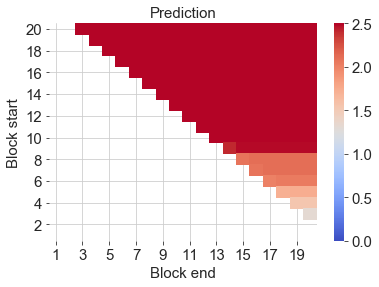

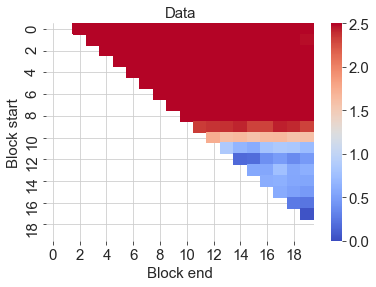

In [54]:
blockdata=pd.read_csv('../Data_ABA_Finkelsteinlab/cas9-target-e-replicate-1-delta-abas_Canonical_OT-r_0-20.csv')
blockdata

def predict_block_mismatches(parameters, model_id, T=60 * 10, guide_length=20, show_plot=True, show_data=True,
                             data_file = '../Data_ABA_Finkelsteinlab/champ-cas9-cas12a-data/cas9-target-e-replicate-1-delta-abas-processed.csv'):
    concentrations = np.array([0.1, 0.3, 1, 3, 10, 30, 100, 300]) #2 ** np.array(range(0, 11)) * 0.5
    reference_conc = 1 #10
    
    epsilon = parameters[:-2]
    energies=ABA.get_energies(epsilon,[], guide_length)
    ontarget_ABA=-np.log(np.sum(np.exp(-np.cumsum(energies))))

    delta_ABA_mat = np.zeros((guide_length, guide_length))
    delta_ABA_mat[:] = np.nan

    for start_of_block in range(1, guide_length + 1):
        for end_of_block in range(start_of_block + 2, guide_length + 1):
            mm_block = list(range(start_of_block, end_of_block)) # Python 3! for python 2, remove the list around it!
            energies=ABA.get_energies(epsilon,mm_block, guide_length)
            rawABA=-np.log(np.sum(np.exp(-np.cumsum(energies))))
            
            delta_ABA_mat[start_of_block - 1, end_of_block - 1] =  rawABA-ontarget_ABA                         
    
    if show_plot:
        ax = sns.heatmap(delta_ABA_mat, cmap='coolwarm', vmin=0, vmax=2.5)
        plt.grid()
        ax.set_xticklabels(list(map(lambda x: str(int(x)), ax.get_xticks() + 0.5)), fontsize=15);
        ax.set_yticklabels(list(map(lambda x: str(int(x)), 20 - ax.get_yticks() + 0.5)), fontsize=15, rotation=0);
        plt.xlabel('Block end', fontsize=15)
        plt.ylabel('Block start', fontsize=15)
        plt.title('Prediction', fontsize=15)

        if show_data:
            plt.figure()
            IlyaData = data_file #pd.read_csv( data_file )
            _, Blocks_heatmap, _ = plot_block_mm_ABA(IlyaData, Plot=False,SaveFigures=False,figure_names=[''])
            sns.heatmap(Blocks_heatmap, cmap='coolwarm', vmin=0, vmax=2.5)
            plt.grid()
            plt.xlabel('Block end', fontsize=15)
            plt.ylabel('Block start', fontsize=15)
            plt.title('Data', fontsize=15)

    return delta_ABA_mat

def plot_block_mm_ABA(data, data_name='Finkelstein Data', Canonical=True, Plot=True,
                      SaveFigures=False, figure_names=['figure1','figure 2']):


    data['Mutation Type'].fillna('', inplace=True)
    select_multi_mm = data['Mutation Type'].apply(lambda x: np.unique(np.array(x.split('|')))[0] == 'r')
    multi_mm_data = data[(data['Canonical'] == Canonical) & (select_multi_mm) & (data['Mutation Count'] > 2)][['Mutation ID', 'Delta ABA (kBT)', 'Uncertainty']]
    multi_mm_data['MM Positions'] = multi_mm_data['Mutation ID'].apply(
        lambda x: list(map(lambda y: int(y.split(':')[1]), x.split('|'))))
    multi_mm_data['Position'] = multi_mm_data['MM Positions'].apply(make_block_ID)
    multi_mm_data = multi_mm_data[(multi_mm_data['Position'] != '')]
    block_mm_data_mean = multi_mm_data[['Position', 'Delta ABA (kBT)', 'Uncertainty']].groupby('Position').mean().reset_index()

    Ng = 20;
    block_mm_map = np.empty((Ng, Ng))
    block_mm_map[:] = np.nan
    for n in range(len(block_mm_data_mean)):
        pos = block_mm_data_mean['Position'].iloc[n]
        Positions = list(map(lambda x: int(x) - 1, pos.split('|')))
        block_mm_map[Positions[0], Positions[1]] = block_mm_data_mean['Delta ABA (kBT)'].iloc[n]

    if Plot:
        plt.figure()
        sns.heatmap(block_mm_map, cmap='coolwarm', cbar=True, vmin=0, vmax=block_mm_data_mean['Delta ABA (kBT)'].max())

        plt.xlabel('Block end', fontsize=15)
        plt.ylabel('Block start', fontsize=15)
        plt.title('$\Delta$ABA - ' + data_name, fontsize=15)
        if not Canonical:
            plt.title('$\Delta$ABA - ' + data_name + ' - Noncanonical', fontsize=15)
        ax = plt.gca()
        ax.set_xticklabels(list(map(lambda x: str(int(x)), ax.get_xticks() + 0.5)),fontsize=15);
        ax.set_yticklabels(list(map(lambda x: str(int(x)), 20 -ax.get_yticks() + 0.5)), fontsize=15,rotation=0);
        if SaveFigures:
            plt.savefig(figure_names[0],format='pdf',bbox_inches='tight')


    block_start_mm_data = block_mm_data_mean.set_index('Position').groupby(
        lambda x: int(x.split('|')[0])).mean().reset_index().rename(columns={'index': 'Block start'})

    if Plot:
        block_start_mm_data.plot(x='Block start', y='Delta ABA (kBT)', yerr='Uncertainty', marker='o', linewidth=1,
                                 color='blue')
        plt.xlabel('Block start', fontsize=15)
        plt.ylabel('$\Delta$ABA', fontsize=15)
        plt.title(data_name, fontsize=15)
        if not Canonical:
            plt.title(data_name + ' - Noncanonical', fontsize=15)


        plt.xticks(fontsize=15);
        plt.yticks(fontsize=15);
        if SaveFigures:
            plt.savefig(figure_names[1],format='pdf',bbox_inches='tight')


    return block_mm_data_mean, block_mm_map, block_start_mm_data

def make_block_ID(MM_pos_list):
    bi = MM_pos_list[0]
    bf = MM_pos_list[-1]
    block = np.arange(bi, bf + 1)
    if (len(block) != len(MM_pos_list)) or np.any(block != np.array(MM_pos_list)):
        return ''
    return '|'.join(list(map(str, [bi, bf])))


_ = predict_block_mismatches(Param_conc3,model_id, T, guide_length, show_plot=True, show_data=True,data_file=blockdata)